In [1]:
import gym
import tensorflow as tf
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
from gym import wrappers
    

%matplotlib inline
# base code from udacity-deep-learning/reinforcement/Q-learning-cart.ipynb


import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# $ CUDA_VISIBLE_DEVICES=0 python my_script.py  # Uses GPU 0.
# $ CUDA_VISIBLE_DEVICES=1 python my_script.py  # Uses GPU 1.
# $ CUDA_VISIBLE_DEVICES=2,3 python my_script.py  # Uses GPUs 2 and 3.

In [2]:
# Create new cart pole environment
env = gym.make('Acrobot-v1')
state = env.reset()
print(state)
action = 2
done = 0
# while not done:
#     env.render()
#     next_state, reward, done, _ = env.step(action)
#     print(next_state)
#     print(reward)
#     print(done)

    
env.close()

[2017-05-27 15:04:24,273] Making new env: Acrobot-v1


[ 0.99859193 -0.05304872  0.99540208  0.09578462 -0.06649392 -0.08276705]


In [3]:
# Create class QNetwork
class QNetwork:
    def __init__(self, \
                 learning_rate=0.01, \
                 state_size=6, 
                 action_size=3, \
                 hidden_size=10, \
                 hidden_layers=2, \
                 alpha=0., \
                 name='QNetwork'):
        
        # create Q Network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, \
                                          [None, state_size], \
                                          name='inputs')
            
            # placeholder for actions, to be one-hot encoded next
            self.actions_ = tf.placeholder(tf.int32, \
                                           [None], \
                                           name='actions')
            
            # one hot encode actions
            one_hot_actions = tf.one_hot(self.actions_, \
                                         action_size)
            
            # placeholder for target Qs
            self.targetQs_ = tf.placeholder(tf.float32, \
                                            [None], \
                                            name='target')
            
                
            # ReLU hidden layers
            self.fc1 = tf.layers.dense(self.inputs_, \
                                        hidden_size,\
                                        activation=None,\
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
            self.fc1 = tf.maximum(alpha*self.fc1,self.fc1)
            
            if hidden_layers == 1:
                out_layer = self.fc1
            else:
                
                self.fc2 = tf.layers.dense(self.fc1, hidden_size,\
                                            activation=None,\
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
                self.fc2 = tf.maximum(alpha*self.fc2,self.fc2)
                
                if hidden_layers == 2:
                    out_layer = self.fc2
                else:
                    self.fc3 = tf.layers.dense(self.fc2, hidden_size,\
                                            activation=None,\
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
                    self.fc3 = tf.maximum(alpha*self.fc3,self.fc3)
                    out_layer = self.fc3

            # Linear output layer
            self.output = tf.layers.dense(out_layer, action_size, \
                                          activation=None,\
                                          kernel_initializer=tf.contrib.layers.xavier_initializer())
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [4]:
# create memory class for storing previous experiences
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [5]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [6]:
def initialize_memory_rand_states(memory_size=1000,pretrain_length=20):
    # Initialize the simulation
    # Make a random action
    env.reset()
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    
    memory = Memory(max_size=memory_size)

    # Make a bunch of random actions and store the experiences
    ii = 0
    while ii < pretrain_length or not done:
        
        # Make a random action
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)

        if done:
            # The simulation fails so no next state
            next_state = np.zeros(state.shape)
            
            # Add experience to memory
            memory.add((state, action, reward, next_state))

            # Start new episode
            state = env.reset()

        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            state = next_state
        
        ii = ii + 1
            
    return memory

In [7]:
def train_q_network(train_episodes=500,\
                   gamma=0.99,\
                   explore_start=1.0,\
                   explore_stop=0.01,\
                   decay_rate=0.0001,\
                   hidden_size=64,\
                   hidden_layers=2,\
                   learning_rate=0.0001,\
                   memory_size=10000,\
                   batch_size=20,\
                   max_steps=500,\
                   alpha=0.,\
                   verbose=True):
    
    
    mainQN = QNetwork(name='main', hidden_size=hidden_size, hidden_layers=hidden_layers, learning_rate=learning_rate, alpha=alpha)
    
    memory = initialize_memory_rand_states(memory_size=memory_size,pretrain_length=batch_size)

    state = env.reset()
    
    # Now train with experiences
    saver = tf.train.Saver()
    rewards_list = []
    with tf.Session() as sess:
        # Initialize variables
        sess.run(tf.global_variables_initializer())

        step = 0
        steps_list = []
        
        for ep in range(train_episodes):
            total_reward = 0
            t = 0
            
            while t < max_steps:
                step += 1
                # Uncomment this next line to watch the training
                # env.render() 

                # Explore or Exploit
                explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
                if explore_p > np.random.rand():
                    # Make a random action
                    action = env.action_space.sample()
                else:
                    # Get action from Q-network
                    feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                    Qs = sess.run(mainQN.output, feed_dict=feed)
                    action = np.argmax(Qs)

                # Take action, get new state and reward
                next_state, reward, done, _ = env.step(action)

                total_reward += reward

                if done:
                    t = t+1
                    # the episode ends so no next state
                    next_state = np.zeros(state.shape)
                    steps_list.append(total_reward)
                    t = max_steps

                    # Add experience to memory
                    memory.add((state, action, reward, next_state))
                    state = env.reset()
                else:
                    # Add experience to memory
                    memory.add((state, action, reward, next_state))
                    state = next_state
                    t += 1

                # Sample mini-batch from memory
                batch = memory.sample(batch_size)
                states = np.array([each[0] for each in batch])
                actions = np.array([each[1] for each in batch])
                rewards = np.array([each[2] for each in batch])
                next_states = np.array([each[3] for each in batch])

                # Train network
                target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})

                # Set target_Qs to 0 for states where episode ends
                episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
                target_Qs[episode_ends] = (0, 0, 0)

                targets = rewards + gamma * np.max(target_Qs, axis=1)

                loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                    feed_dict={mainQN.inputs_: states,
                                               mainQN.targetQs_: targets,
                                               mainQN.actions_: actions})
            
            rewards_list.append((ep, total_reward))   
            runningMean = np.mean(steps_list[-100:])
            if verbose:
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                      'RunMean : {:.4f}'.format(runningMean))
               
            
            
            if runningMean > -60.:
                saver.save(sess, "checkpoints/cartpole.ckpt")
                return rewards_list, mainQN, saver, runningMean
            
        saver.save(sess, "checkpoints/cartpole.ckpt")
        return rewards_list, mainQN, saver, runningMean

In [8]:
def plot_rewards(rewards_list):
    eps, rews = np.array(rewards_list).T
    smoothed_rews = running_mean(rews, 10)
    plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
    plt.plot(eps, rews, color='grey', alpha=0.3)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

In [9]:
def test_q_network(mainQN, saver, test_episodes=100, test_max_steps=500, render=True):


    tot_rewards = 0.
    rewards_list = []
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
   
        state = env.reset()
        for ep in range(test_episodes):
            t = 0
            while t < test_max_steps:
                if render:
                    env.render() 

                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)

                # Take action, get new state and reward
                next_state, reward, done, _ = env.step(action)
                
                tot_rewards = tot_rewards + reward
                
                if done:
                    t = test_max_steps
                    state = env.reset()
                    # Take one random step to get the pole and cart moving
                    #state, reward, done, _ = env.step(env.action_space.sample())
                    rewards_list.append(tot_rewards)
                    tot_rewards = 0.
                else:
                    state = next_state
                    t += 1
    mean_rewards = np.mean(rewards_list)         
    return mean_rewards

In [10]:
def test_and_train_qnetwork(train_episodes=1000,\
                   gamma=0.99,\
                   explore_start=1.0,\
                   explore_stop=0.0,\
                   decay_rate=0.0001,\
                   hidden_size=64,\
                   hidden_layers=2,\
                   learning_rate=0.001,\
                   memory_size=10000,\
                   batch_size=20,\
                   test_episodes=10,\
                   render=False,\
                   alpha=0.,\
                   verbose=True):
    
    # reset graph
    tf.reset_default_graph()

    # train q-network
    rewards_list, mainQN, saver, runMean = train_q_network(train_episodes = train_episodes, \
                                                  gamma=gamma,\
                                                  explore_start=explore_start,\
                                                  explore_stop=explore_stop,\
                                                  decay_rate=decay_rate,\
                                                  hidden_size=hidden_size,\
                                                  hidden_layers=hidden_layers,\
                                                  learning_rate=learning_rate,\
                                                  memory_size=memory_size,\
                                                  batch_size=batch_size,\
                                                  alpha=alpha,\
                                                  verbose=verbose)

    if verbose:
        # plot training
        plot_rewards(rewards_list)
    

    avg_train_rewards = np.sum([each[1] for each in rewards_list]) / len(rewards_list)
#     max_train_rewards = np.max([each[1] for each in rewards_list])
    if verbose:
        print('average training reward = ',avg_train_rewards)

    # test q-network
    avg_test_rewards = test_q_network(mainQN, saver, test_episodes=test_episodes, render=verbose)
    
    if verbose:
        print('average test reward = ', avg_test_rewards)
    
    return avg_test_rewards, runMean, mainQN, saver, len(rewards_list)


[2017-05-27 14:13:39,212] Making new env: Acrobot-v1
[2017-05-27 14:13:39,214] Clearing 24 monitor files from previous run (because force=True was provided)
[2017-05-27 14:13:40,431] Starting new video recorder writing to D:\tmp\acrobot-experiment-1\openaigym.video.0.10772.video000000.mp4
[2017-05-27 14:13:50,600] Starting new video recorder writing to D:\tmp\acrobot-experiment-1\openaigym.video.0.10772.video000001.mp4


Episode: 0 Total reward: -500.0 Training loss: 14.3324 Explore P: 0.9048 RunMean : -500.0000
Episode: 1 Total reward: -486.0 Training loss: 12.4525 Explore P: 0.8209 RunMean : -493.0000
Episode: 2 Total reward: -336.0 Training loss: 8.5973 Explore P: 0.7674 RunMean : -440.6667
Episode: 3 Total reward: -380.0 Training loss: 13.7218 Explore P: 0.7111 RunMean : -425.5000
Episode: 4 Total reward: -454.0 Training loss: 8.3095 Explore P: 0.6492 RunMean : -431.2000


[2017-05-27 14:14:06,993] Starting new video recorder writing to D:\tmp\acrobot-experiment-1\openaigym.video.0.10772.video000008.mp4


Episode: 5 Total reward: -444.0 Training loss: 10.2077 Explore P: 0.5939 RunMean : -433.3333
Episode: 6 Total reward: -500.0 Training loss: 5.9303 Explore P: 0.5374 RunMean : -442.8571
Episode: 7 Total reward: -448.0 Training loss: 29.1629 Explore P: 0.4913 RunMean : -443.5000
Episode: 8 Total reward: -500.0 Training loss: 45.9373 Explore P: 0.4445 RunMean : -449.7778
Episode: 9 Total reward: -500.0 Training loss: 10.8766 Explore P: 0.4022 RunMean : -454.8000
Episode: 10 Total reward: -500.0 Training loss: 52.2865 Explore P: 0.3639 RunMean : -458.9091
Episode: 11 Total reward: -365.0 Training loss: 18.1040 Explore P: 0.3382 RunMean : -451.0833
Episode: 12 Total reward: -500.0 Training loss: 10.8892 Explore P: 0.3061 RunMean : -454.8462
Episode: 13 Total reward: -384.0 Training loss: 219.0972 Explore P: 0.2834 RunMean : -449.7857
Episode: 14 Total reward: -500.0 Training loss: 9.3904 Explore P: 0.2564 RunMean : -453.1333
Episode: 15 Total reward: -500.0 Training loss: 16.7970 Explore P:

[2017-05-27 14:14:46,057] Starting new video recorder writing to D:\tmp\acrobot-experiment-1\openaigym.video.0.10772.video000027.mp4


Episode: 24 Total reward: -202.0 Training loss: 5.5231 Explore P: 0.1193 RunMean : -424.6400
Episode: 25 Total reward: -183.0 Training loss: 6.7272 Explore P: 0.1150 RunMean : -415.3462
Episode: 26 Total reward: -231.0 Training loss: 12.0029 Explore P: 0.1098 RunMean : -408.5185
Episode: 27 Total reward: -211.0 Training loss: 25.8273 Explore P: 0.1052 RunMean : -401.4643
Episode: 28 Total reward: -227.0 Training loss: 11.9298 Explore P: 0.1005 RunMean : -395.4483
Episode: 29 Total reward: -150.0 Training loss: 21.8064 Explore P: 0.0975 RunMean : -387.2667
Episode: 30 Total reward: -128.0 Training loss: 9.9732 Explore P: 0.0950 RunMean : -378.9032
Episode: 31 Total reward: -316.0 Training loss: 14.0398 Explore P: 0.0892 RunMean : -376.9375
Episode: 32 Total reward: -121.0 Training loss: 14.4431 Explore P: 0.0871 RunMean : -369.1818
Episode: 33 Total reward: -165.0 Training loss: 13.5520 Explore P: 0.0842 RunMean : -363.1765
Episode: 34 Total reward: -135.0 Training loss: 6.4009 Explore 

[2017-05-27 14:15:26,842] Starting new video recorder writing to D:\tmp\acrobot-experiment-1\openaigym.video.0.10772.video000064.mp4


Episode: 61 Total reward: -115.0 Training loss: 3.2965 Explore P: 0.0393 RunMean : -260.1290
Episode: 62 Total reward: -117.0 Training loss: 4.4724 Explore P: 0.0384 RunMean : -257.8571
Episode: 63 Total reward: -135.0 Training loss: 8.9516 Explore P: 0.0374 RunMean : -255.9375
Episode: 64 Total reward: -95.0 Training loss: 3.2227 Explore P: 0.0367 RunMean : -253.4615
Episode: 65 Total reward: -96.0 Training loss: 4.2473 Explore P: 0.0360 RunMean : -251.0758
Episode: 66 Total reward: -83.0 Training loss: 5.7654 Explore P: 0.0354 RunMean : -248.5672
Episode: 67 Total reward: -85.0 Training loss: 4.3838 Explore P: 0.0348 RunMean : -246.1618
Episode: 68 Total reward: -92.0 Training loss: 3.0446 Explore P: 0.0341 RunMean : -243.9275
Episode: 69 Total reward: -338.0 Training loss: 7.0566 Explore P: 0.0319 RunMean : -245.2714
Episode: 70 Total reward: -96.0 Training loss: 5.4665 Explore P: 0.0313 RunMean : -243.1690
Episode: 71 Total reward: -104.0 Training loss: 4.2883 Explore P: 0.0306 Run

[2017-05-27 14:16:24,386] Starting new video recorder writing to D:\tmp\acrobot-experiment-1\openaigym.video.0.10772.video000125.mp4


Episode: 122 Total reward: -110.0 Training loss: 5.8172 Explore P: 0.0095 RunMean : -129.9500
Episode: 123 Total reward: -124.0 Training loss: 7.1110 Explore P: 0.0093 RunMean : -128.6300
Episode: 124 Total reward: -113.0 Training loss: 8.8850 Explore P: 0.0091 RunMean : -127.7400
Episode: 125 Total reward: -131.0 Training loss: 4.3446 Explore P: 0.0089 RunMean : -127.2200
Episode: 126 Total reward: -93.0 Training loss: 4.1852 Explore P: 0.0087 RunMean : -125.8400
Episode: 127 Total reward: -79.0 Training loss: 2.6654 Explore P: 0.0085 RunMean : -124.5200
Episode: 128 Total reward: -112.0 Training loss: 2.4275 Explore P: 0.0084 RunMean : -123.3700
Episode: 129 Total reward: -98.0 Training loss: 3.8092 Explore P: 0.0082 RunMean : -122.8500
Episode: 130 Total reward: -81.0 Training loss: 3.9755 Explore P: 0.0081 RunMean : -122.3800
Episode: 131 Total reward: -103.0 Training loss: 3.2483 Explore P: 0.0079 RunMean : -120.2500
Episode: 132 Total reward: -149.0 Training loss: 8.5638 Explore 

[2017-05-27 14:17:43,775] Starting new video recorder writing to D:\tmp\acrobot-experiment-1\openaigym.video.0.10772.video000216.mp4


Episode: 213 Total reward: -128.0 Training loss: 3.9442 Explore P: 0.0012 RunMean : -114.5300
Episode: 214 Total reward: -500.0 Training loss: 3.5306 Explore P: 0.0011 RunMean : -118.3500
Episode: 215 Total reward: -105.0 Training loss: 4.5613 Explore P: 0.0010 RunMean : -118.2200
Episode: 216 Total reward: -76.0 Training loss: 4.0832 Explore P: 0.0010 RunMean : -117.7200
Episode: 217 Total reward: -71.0 Training loss: 2.9461 Explore P: 0.0010 RunMean : -117.6300
Episode: 218 Total reward: -98.0 Training loss: 7.8747 Explore P: 0.0010 RunMean : -117.2600
Episode: 219 Total reward: -148.0 Training loss: 5.5481 Explore P: 0.0010 RunMean : -117.4300
Episode: 220 Total reward: -71.0 Training loss: 10.8208 Explore P: 0.0009 RunMean : -116.9000
Episode: 221 Total reward: -79.0 Training loss: 5.7130 Explore P: 0.0009 RunMean : -116.3500
Episode: 222 Total reward: -113.0 Training loss: 2.8961 Explore P: 0.0009 RunMean : -116.3800
Episode: 223 Total reward: -105.0 Training loss: 3.2483 Explore 

[2017-05-27 14:19:37,325] Starting new video recorder writing to D:\tmp\acrobot-experiment-1\openaigym.video.0.10772.video000343.mp4


Episode: 340 Total reward: -120.0 Training loss: 2.8356 Explore P: 0.0001 RunMean : -112.3600
Episode: 341 Total reward: -115.0 Training loss: 3.1086 Explore P: 0.0001 RunMean : -112.5600
Episode: 342 Total reward: -143.0 Training loss: 2.8727 Explore P: 0.0001 RunMean : -113.0700
Episode: 343 Total reward: -103.0 Training loss: 4.0272 Explore P: 0.0001 RunMean : -112.7400
Episode: 344 Total reward: -171.0 Training loss: 2.6168 Explore P: 0.0001 RunMean : -112.7700
Episode: 345 Total reward: -77.0 Training loss: 2.9806 Explore P: 0.0001 RunMean : -112.5100
Episode: 346 Total reward: -97.0 Training loss: 3.6309 Explore P: 0.0001 RunMean : -112.2000
Episode: 347 Total reward: -100.0 Training loss: 3.5664 Explore P: 0.0001 RunMean : -112.2000
Episode: 348 Total reward: -87.0 Training loss: 2.9541 Explore P: 0.0001 RunMean : -111.8700
Episode: 349 Total reward: -129.0 Training loss: 5.4393 Explore P: 0.0001 RunMean : -112.3100
Episode: 350 Total reward: -127.0 Training loss: 2.7162 Explore

[2017-05-27 14:22:10,508] Starting new video recorder writing to D:\tmp\acrobot-experiment-1\openaigym.video.0.10772.video000512.mp4


Episode: 509 Total reward: -124.0 Training loss: 2.9420 Explore P: 0.0000 RunMean : -115.3100
Episode: 510 Total reward: -117.0 Training loss: 1.9882 Explore P: 0.0000 RunMean : -115.8500
Episode: 511 Total reward: -86.0 Training loss: 2.2646 Explore P: 0.0000 RunMean : -115.4600
Episode: 512 Total reward: -76.0 Training loss: 4.3098 Explore P: 0.0000 RunMean : -115.0800
Episode: 513 Total reward: -112.0 Training loss: 3.7416 Explore P: 0.0000 RunMean : -115.0700
Episode: 514 Total reward: -79.0 Training loss: 4.5391 Explore P: 0.0000 RunMean : -114.5800
Episode: 515 Total reward: -92.0 Training loss: 2.7870 Explore P: 0.0000 RunMean : -114.4500
Episode: 516 Total reward: -84.0 Training loss: 3.5792 Explore P: 0.0000 RunMean : -114.5300
Episode: 517 Total reward: -62.0 Training loss: 12.3128 Explore P: 0.0000 RunMean : -114.0100
Episode: 518 Total reward: -84.0 Training loss: 1.7972 Explore P: 0.0000 RunMean : -113.6500
Episode: 519 Total reward: -152.0 Training loss: 4.0260 Explore P:

[2017-05-27 14:24:35,216] Starting new video recorder writing to D:\tmp\acrobot-experiment-1\openaigym.video.0.10772.video000729.mp4


Episode: 726 Total reward: -90.0 Training loss: 2.9891 Explore P: 0.0000 RunMean : -105.4100
Episode: 727 Total reward: -134.0 Training loss: 2.3991 Explore P: 0.0000 RunMean : -106.1300
Episode: 728 Total reward: -102.0 Training loss: 3.3943 Explore P: 0.0000 RunMean : -106.3200
Episode: 729 Total reward: -90.0 Training loss: 4.0541 Explore P: 0.0000 RunMean : -105.6700
Episode: 730 Total reward: -107.0 Training loss: 5.0604 Explore P: 0.0000 RunMean : -106.0000
Episode: 731 Total reward: -118.0 Training loss: 3.4035 Explore P: 0.0000 RunMean : -106.2500
Episode: 732 Total reward: -94.0 Training loss: 2.5027 Explore P: 0.0000 RunMean : -106.3400
Episode: 733 Total reward: -121.0 Training loss: 4.7819 Explore P: 0.0000 RunMean : -106.6100
Episode: 734 Total reward: -123.0 Training loss: 2.9136 Explore P: 0.0000 RunMean : -107.1400
Episode: 735 Total reward: -116.0 Training loss: 2.6060 Explore P: 0.0000 RunMean : -107.4000
Episode: 736 Total reward: -84.0 Training loss: 3.1666 Explore 

[2017-05-27 14:26:43,629] Starting new video recorder writing to D:\tmp\acrobot-experiment-1\openaigym.video.0.10772.video001000.mp4


Episode: 997 Total reward: -104.0 Training loss: 1.7296 Explore P: 0.0000 RunMean : -106.2300
Episode: 998 Total reward: -90.0 Training loss: 2.3726 Explore P: 0.0000 RunMean : -106.0500
Episode: 999 Total reward: -139.0 Training loss: 2.6700 Explore P: 0.0000 RunMean : -106.1200
Episode: 1000 Total reward: -91.0 Training loss: 3.7353 Explore P: 0.0000 RunMean : -105.8500
Episode: 1001 Total reward: -101.0 Training loss: 3.3039 Explore P: 0.0000 RunMean : -105.7900
Episode: 1002 Total reward: -102.0 Training loss: 2.0436 Explore P: 0.0000 RunMean : -105.7400
Episode: 1003 Total reward: -112.0 Training loss: 1.9255 Explore P: 0.0000 RunMean : -105.9800
Episode: 1004 Total reward: -119.0 Training loss: 3.1433 Explore P: 0.0000 RunMean : -105.8900
Episode: 1005 Total reward: -120.0 Training loss: 3.6602 Explore P: 0.0000 RunMean : -105.5500
Episode: 1006 Total reward: -90.0 Training loss: 2.7404 Explore P: 0.0000 RunMean : -103.8400
Episode: 1007 Total reward: -104.0 Training loss: 5.1396

[2017-05-27 14:34:59,735] Starting new video recorder writing to D:\tmp\acrobot-experiment-1\openaigym.video.0.10772.video002000.mp4


Episode: 1997 Total reward: -107.0 Training loss: 3.0632 Explore P: 0.0000 RunMean : -98.6800
Episode: 1998 Total reward: -77.0 Training loss: 1.0444 Explore P: 0.0000 RunMean : -98.7400
Episode: 1999 Total reward: -69.0 Training loss: 3.3945 Explore P: 0.0000 RunMean : -98.7300
average training reward =  -108.735
INFO:tensorflow:Restoring parameters from checkpoints\cartpole.ckpt


[2017-05-27 14:35:01,820] Restoring parameters from checkpoints\cartpole.ckpt


average test reward =  -86.2
average test reward =  (-86.200000000000003, -98.730000000000004, <__main__.QNetwork object at 0x0000022260D2F4A8>, <tensorflow.python.training.saver.Saver object at 0x000002225F9D2C18>, 2000)


<bound method Monitor.close of <Monitor<TimeLimit<AcrobotEnv<Acrobot-v1>>>>>

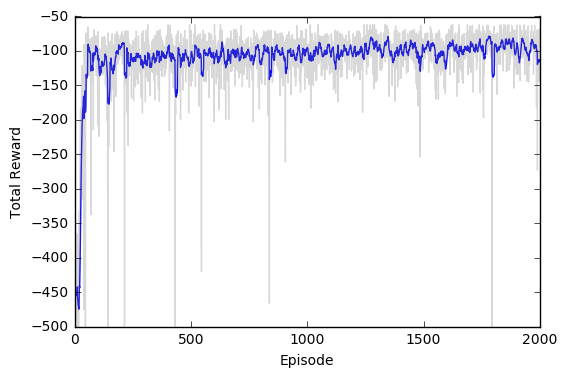

In [12]:
env = gym.make('Acrobot-v1')
env = wrappers.Monitor(env, '/tmp/acrobot-experiment-1',force=True)

# test implementation
average_rewards = test_and_train_qnetwork(train_episodes=2000, verbose=True,\
                                         gamma=0.999,\
                                         decay_rate=0.0002,\
                                         explore_start=1.0,\
                                         explore_stop=0.0,\
                                         hidden_size=64,\
                                         hidden_layers=2,\
                                         learning_rate=0.0005,\
                                         batch_size=64,\
                                         alpha=0.1)
print('average test reward = ', average_rewards)

env.close

In [ ]:
train_eps = 10000
verb = False
gamma = [0.999,0.99]
decay_rate = [0.0001,0.00002]
exp_start=1.0
exp_stop=0.0
hidden_size=[32]
hidden_layers=[2]
learning_rate=[0.00001,0.0001,0.001]
batch_size=[64]
num_averages = 1
results = []
alpha_relu = [0.1]
mem_size = [10000]
env = gym.make('Acrobot-v1')
env.reset()

for gaIndex in range(len(gamma)):
    for drIndex in range(len(decay_rate)):
        for hs in hidden_size:
            for hl in hidden_layers:
                for lr in learning_rate:
                    for bs in batch_size:
                        for alu in alpha_relu:
                            for mems in mem_size:
                                ga = gamma[gaIndex]
                                dr = decay_rate[drIndex]
                                train_params_name = 'dr='+str(dr)+'_ga='+str(ga)+'_hs='+str(hs)+'_hl'+str(hl)+'_lr'+str(lr)+'_bs'+str(bs)+'_alu='+str(alu)+'_mm='+str(mems)
                                average_test_rewards = 0.
                                average_train_rewards = 0.
                                for i in range(num_averages):
                                    test,train, mainQN, saver, num_episodes = test_and_train_qnetwork(memory_size=mems,\
                                                           train_episodes=train_eps,\
                                                           gamma=ga,\
                                                           explore_start=exp_start,\
                                                           explore_stop=exp_stop,\
                                                           decay_rate=dr,\
                                                           hidden_layers=hl,\
                                                           hidden_size=hs,\
                                                           learning_rate=lr,\
                                                           batch_size=bs,\
                                                           alpha = alu,\
                                                           verbose=verb)
                                    average_test_rewards += test
                                    average_train_rewards += train

                                average_test_rewards = average_test_rewards / num_averages
                                average_train_rewards = average_train_rewards / num_averages
                                results.append([train_params_name+' test='+str(average_test_rewards)+'  train='+str(average_train_rewards)+'  numpEps='+str(num_episodes)])
                                clear_output()
                                for each in results:
                                    print(each)
env.close()

[2017-05-27 15:04:32,774] Making new env: Acrobot-v1


In [20]:
from gym import wrappers
    
env = gym.make('CartPole-v1')
#env = wrappers.Monitor(env, '/tmp/cartpole-experiment-1',force=True)

test,train, mainQN, saver, num_episodes = test_and_train_qnetwork(memory_size=10000,\
                                     train_episodes=4000,\
                                           gamma=0.999,\
                                           explore_start=1.,\
                                           explore_stop=0.0,\
                                           decay_rate=0.00002,\
                                           hidden_layers=1,\
                                           hidden_size=32,\
                                           learning_rate=0.001,\
                                           batch_size=64,\
                                           alpha=0.1,\
                                           verbose=True)
print('test=',str(test))
print(train)
print('number of episodes=',str(num_episodes))
env.close()

[2017-05-27 13:19:28,522] Making new env: CartPole-v1


ValueError: Cannot feed value of shape (64, 4) for Tensor 'main/inputs:0', which has shape '(?, 6)'

In [13]:
env = gym.make('CartPole-v1')
env = wrappers.Monitor(env, '/tmp/cartpole-experiment-1',force=True)
avg_test_rewards = test_q_network(mainQN, saver, test_episodes=200, render=False)
print(avg_test_rewards)
env.close
#     if verbose:
#         print('average test reward = ', avg_test_rewards)
    
#     return avg_test_rewards, avg_train_rewards, mainQN, saver

[2017-05-22 23:50:18,379] Making new env: CartPole-v0
[2017-05-22 23:50:18,382] Clearing 4 monitor files from previous run (because force=True was provided)


INFO:tensorflow:Restoring parameters from checkpoints\cartpole.ckpt


[2017-05-22 23:50:18,392] Restoring parameters from checkpoints\cartpole.ckpt
[2017-05-22 23:50:18,484] Starting new video recorder writing to D:\tmp\cartpole-experiment-1\openaigym.video.0.2564.video000000.mp4
[2017-05-22 23:50:21,927] Starting new video recorder writing to D:\tmp\cartpole-experiment-1\openaigym.video.0.2564.video000001.mp4
[2017-05-22 23:50:25,823] Starting new video recorder writing to D:\tmp\cartpole-experiment-1\openaigym.video.0.2564.video000008.mp4
[2017-05-22 23:50:30,765] Starting new video recorder writing to D:\tmp\cartpole-experiment-1\openaigym.video.0.2564.video000027.mp4
[2017-05-22 23:50:37,157] Starting new video recorder writing to D:\tmp\cartpole-experiment-1\openaigym.video.0.2564.video000064.mp4
[2017-05-22 23:50:45,686] Starting new video recorder writing to D:\tmp\cartpole-experiment-1\openaigym.video.0.2564.video000125.mp4


199.9999999998906


<bound method Monitor.close of <Monitor<TimeLimit<CartPoleEnv<CartPole-v0>>>>>

In [13]:
env.close()
gym.upload('/tmp/acrobot-experiment-1', api_key='sk_2nAEHbARwKPuKcao8nWRw')

[2017-05-27 13:46:29,408] Finished writing results. You can upload them to the scoreboard via gym.upload('D:\\tmp\\acrobot-experiment-1')
[2017-05-27 13:46:29,411] [Acrobot-v1] Uploading 1011 episodes of training data
[2017-05-27 13:46:31,125] [Acrobot-v1] Uploading videos of 11 training episodes (1329615 bytes)
[2017-05-27 13:46:32,559] [Acrobot-v1] Creating evaluation object from /tmp/acrobot-experiment-1 with learning curve and training video
[2017-05-27 13:46:32,866] 
****************************************************
You successfully uploaded your evaluation on Acrobot-v1 to
OpenAI Gym! You can find it at:

    https://gym.openai.com/evaluations/eval_PfjvHi6oSPOyruibcH6beQ

****************************************************


In [19]:
import gym
from gym import wrappers
env = gym.make('CartPole-v1')
env = wrappers.Monitor(env, '/tmp/acrobot-experiment-1',force=True)
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

[2017-05-27 13:18:59,153] Making new env: CartPole-v1
[2017-05-27 13:18:59,155] Clearing 22 monitor files from previous run (because force=True was provided)
[2017-05-27 13:18:59,161] Starting new video recorder writing to D:\tmp\acrobot-experiment-1\openaigym.video.3.5636.video000000.mp4


KeyboardInterrupt: 

[2017-05-27 13:19:07,935] Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\drbur\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-52903a4260e1>", line 6, in <module>
    observation = env.reset()
  File "d:\git\gym\gym\core.py", line 107, in reset
    return self._reset()
  File "d:\git\gym\gym\wrappers\monitoring.py", line 41, in _reset
    self._after_reset(observation)
  File "d:\git\gym\gym\wrappers\monitoring.py", line 198, in _after_reset
    self._reset_video_recorder()
  File "d:\git\gym\gym\wrappers\monitoring.py", line 219, in _reset_video_recorder
    self.video_recorder.capture_frame()
  File "d:\git\gym\gym\monitoring\video_recorder.py", line 106, in capture_frame
    frame = self.env.render(mode=render_mode)
  File "d:\git\gym\gym\core.py", line 153, in render
    return self._render(mode=mode, close=close)
  File "d:\git\gym\gym\core.py", line 285, in _re

KeyboardInterrupt: 